# **Title - Exploratory Data Analysis on Indian Premier League**


> Author : Sai Phyo Hein

> Work : Intership Program in The Spark Foundation

> Batch : August21#



---



# 1. Outline



1.   Outline
2.   Importing Required Modules
3.   Reading Data from Source Zip
4.   Exploring Data
5.   Team - Teams with Maximum Winner Count
6.   Player - Maximum "Player_of_Match" award Holder (Seasonal & Overall) 
7.   Player - Batting Performance Analysis (Strike Rate)
8.   Player - Bowling Performance Analysis (Dot Ball %)




---



# 2. Importing Required Modules

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore", category=Warning)

# 3. Reading Data from Source Zip

> **3.1** I have downloaded the data zip file and uploaded in my google drive. 
This step is to unzip the zip file from drive and add a copy in this notebook's workspace.



In [ ]:
!unzip /content/drive/MyDrive/Data_for_Data_Science_Projects/Indian_Premier_League.zip 



> **3.2**  This step is to read those unzipped csv files and store in pandas dataframe variable.



In [4]:
#Deliveries Data from deliveries.csv
deliveries = pd.read_csv("/content/deliveries.csv")

#Match data from matches.csv
#with parsing datetime to respective columns for ease of representing sequential in filtering and visualizing
matches = pd.read_csv("/content/matches.csv", parse_dates= ["season", "date"])

# 4. Exploring Data



> **4.1** This step is checking for missing values in data, those can become noise or mis-interpreting in analysis. 



In [5]:
deliveries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179078 entries, 0 to 179077
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   match_id          179078 non-null  int64 
 1   inning            179078 non-null  int64 
 2   batting_team      179078 non-null  object
 3   bowling_team      179078 non-null  object
 4   over              179078 non-null  int64 
 5   ball              179078 non-null  int64 
 6   batsman           179078 non-null  object
 7   non_striker       179078 non-null  object
 8   bowler            179078 non-null  object
 9   is_super_over     179078 non-null  int64 
 10  wide_runs         179078 non-null  int64 
 11  bye_runs          179078 non-null  int64 
 12  legbye_runs       179078 non-null  int64 
 13  noball_runs       179078 non-null  int64 
 14  penalty_runs      179078 non-null  int64 
 15  batsman_runs      179078 non-null  int64 
 16  extra_runs        179078 non-null  int

**Explanation:**

> Column indexes [0, 17] have no missing values and some info about dismissal and fielder are not recorded as those are not common in a normal match. 



> So, no special processing for common informations is required, as there is no missing. 






In [6]:
matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id               756 non-null    int64         
 1   season           756 non-null    datetime64[ns]
 2   city             749 non-null    object        
 3   date             756 non-null    datetime64[ns]
 4   team1            756 non-null    object        
 5   team2            756 non-null    object        
 6   toss_winner      756 non-null    object        
 7   toss_decision    756 non-null    object        
 8   result           756 non-null    object        
 9   dl_applied       756 non-null    int64         
 10  winner           752 non-null    object        
 11  win_by_runs      756 non-null    int64         
 12  win_by_wickets   756 non-null    int64         
 13  player_of_match  752 non-null    object        
 14  venue            756 non-null    object   

**Explanation:**


> city, winner, player_of_match, umpires columns have unrecorded data. Dropping or filling will depend on specific process - so preprocessing will be done before each specific process. 



**4.2** Task in the next section is which teams are winning the most in each season and which teams are winning most seasons. 

Thus, missing values in a common info (winner) columns must be checked and prepared for this reason. 

In [7]:
print(matches[matches["winner"].isnull()].index)
matches[matches["winner"].isnull()]

Int64Index([300, 545, 570, 744], dtype='int64')


,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
300,301,2011-01-01,Delhi,2011-05-21,Delhi Daredevils,Pune Warriors,Delhi Daredevils,bat,no result,0,NaN,0,0,NaN,Feroz Shah Kotla,SS Hazare,RJ Tucker,NaN
545,546,2015-01-01,Bangalore,2015-04-29,Royal Challengers Bangalore,Rajasthan Royals,Rajasthan Royals,field,no result,0,NaN,0,0,NaN,M Chinnaswamy Stadium,JD Cloete,PG Pathak,NaN
570,571,2015-01-01,Bangalore,2015-05-17,Delhi Daredevils,Royal Challengers Bangalore,Royal Challengers Bangalore,field,no result,0,NaN,0,0,NaN,M Chinnaswamy Stadium,HDPK Dharmasena,K Srinivasan,NaN
744,11340,2019-01-01,Bengaluru,2019-04-30,Royal Challengers Bangalore,Rajasthan Royals,Rajasthan Royals,field,no result,0,NaN,0,0,NaN,M. Chinnaswamy Stadium,Nigel Llong,Ulhas Gandhe,Anil Chaudhary


**Explanation:**
> Seeing other items of missing data for winner, those may be unrecorded because the match is canceled on that day. 

> Season column in datetime format with (year-month-day) can also be a problem in filtering and visualization so this must be changed to datetime format (year). 





In [8]:
#modifying the season column to just year. 
import datetime as dt
matches["season"] = matches["season"].dt.year

**4.3** This step is to check number of matches in each season making sure there is no match with very few matches or with unresonably large number of matches. 

4.3.1 Make a copy of matches df as work_matches df so that no interference with main matches df. 
Counting matches with no result is not reasonable and must drop rows with no match.

In [9]:
work_matches = matches.copy()
work_matches.drop(list(work_matches[work_matches["winner"].isnull()].index), inplace = True)

4.3.2 Counting number of matches in each season and visualizing with seaborn. 

Text(0.5, 1.0, 'Number of Matches per Season')

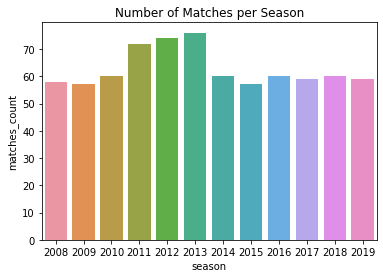

In [10]:
matches_per_season = pd.DataFrame(work_matches.groupby("season").count()["id"])
matches_per_season.rename(columns = {"id":"matches_count"}, inplace= True)
sns.barplot(matches_per_season.index, matches_per_season["matches_count"]).set_title("Number of Matches per Season")

**Explanation:** 

No season with strange number of matches. 

Showing the winning count for overall will also be reasonable as the match counts are not much different. 

But I would like to anlyze sesonalize seasonally to see the detail of improvement by those max winning teams. 


# 5. Teams with Maximum Winner Count
To check which teams have won the most matches in each season. 

**5.1** Work Flow

*Use work_matches df*
* get a dataframe with a column for unique seasons, another column for teams with maximum winning counts in specific season and the last their winning match counts. 
* plot the result and print out the stats of resulting dataframe. 



Number of Seasons Winning by Teams
...............................................................


,
Mumbai Indians,4
Chennai Super Kings,3
Delhi Daredevils,1


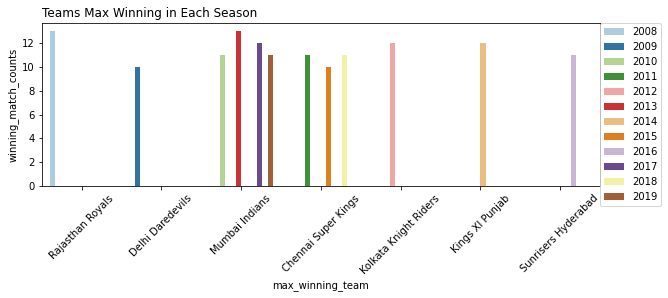

In [54]:
# get dataframe with uniqe season column, team with max winning count and number of winning matches. 

max_winning = pd.DataFrame(columns = ["season", "max_winning_team", "winning_match_counts"])

#******
for season in sorted(work_matches["season"].unique()):
  point = {}
  point["season"] = [season]

  temp_df = pd.DataFrame(work_matches[work_matches["season"] == season].groupby("winner").count()["id"])

  point["max_winning_team"] = [temp_df["id"].idxmax()]
  point["winning_match_counts"] = [temp_df["id"].max()]

  temp_df2 = pd.DataFrame.from_dict(point)

  max_winning = pd.concat([max_winning, temp_df2], ignore_index= True)

# plot the result
fig, axe = plt.subplots(1, figsize = (10, 3))

sns.barplot(ax = axe, x = "max_winning_team", y = "winning_match_counts", hue = "season", 
            data = max_winning, palette = "Paired").set_title("Teams Max Winning in Each Season", loc = "left")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0)

plt.xticks(rotation = 45)

# Print the stats
print("Number of Seasons Winning by Teams")
print("...............................................................")

no_of_season_win = pd.DataFrame(max_winning.groupby(
    "max_winning_team").count()).sort_values("season", ascending = False).head(3).drop("winning_match_counts", axis = 1)

no_of_season_win.rename(columns = {"season":""}, inplace = True)
no_of_season_win.index.name = None
no_of_season_win

**Explanation:**

From above, the best team to promote currently is Mumbai Indians, followed by Chennai Super Kings. 

#6. Maximum "Player of Match" Holder (Seasonal & Overall)
Ranking players with the number of "Player of Match" award. 

**6.1** Work Flow
* Get a dataframe with a column for unique season, a column for player name and the last for no. of Player of Match award the player get. 
* Get another dataframe for each player and no. of POM the player get for throughout all season. 
* Plot the resultants. 
POM = Player of Match

In [80]:
# get a dataframe with a column for unique season, a column for player name and the last for
# no. of Player of Match award the player get. 

pom_df = pd.DataFrame(columns = ["season","player", "num_of_POM"])

matches_for_pom = work_matches[["id", "season", "player_of_match"]]

for season in work_matches.season.unique():

  temp_dict = {}
  temp_dict["season"] = [season]

  temp_df = matches_for_pom[matches_for_pom["season"]==season].groupby(
      by = "player_of_match", as_index = False).count().sort_values(by = "id", ascending = False)

  temp_dict["player"] = [temp_df["player_of_match"].values[0]]
  temp_dict["num_of_POM"] = [temp_df ["id"].values[0]]
  
  temp_df2 = pd.DataFrame.from_dict(temp_dict)

  pom_df = pd.concat([pom_df, temp_df2], ignore_index = True)

In [81]:
# get a dataframe for each player and no. of POM the player get for throughout all season. 
overall_pom_df = matches_for_pom.groupby("player_of_match", as_index = False).count().sort_values(by= "id", ascending = False)
overall_pom_df.rename(columns = {"player_of_match":"player", "id":"Number of POM"}, inplace = True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text major ticklabel objects>)

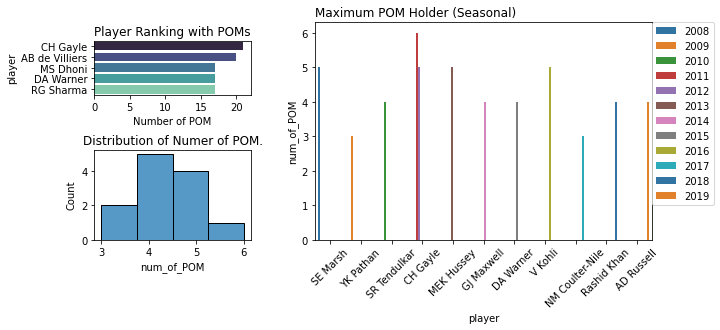

In [97]:
#Plot the resultants

fig = plt.figure(figsize = (10, 4))

gs = gridspec.GridSpec(4,4, figure = fig, width_ratios= [1, 0.1, 1, 1], height_ratios=[0.1, 0.6, 0.4, 1])

fig.tight_layout(pad = 3.0)

axe1 = fig.add_subplot(gs[1,0])
sns.barplot(ax = axe1, x =  "Number of POM", y = "player", data = overall_pom_df.head(),
            palette = "mako").set_title("Player Ranking with POMs", loc = "left")

axe2 = fig.add_subplot(gs[-1, 0])
sns.histplot(pom_df["num_of_POM"], bins = 4 , ax = axe2).set_title("Distribution of Numer of POM.")

axe3 = fig.add_subplot(gs[:, 2:])
sns.barplot(ax = axe3, x = "player", y = "num_of_POM", hue = "season", data = pom_df.sort_values("season"),
            palette = "tab10").set_title("Maximum POM Holder (Seasonal)", loc = "left")

axe3.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0)
plt.xticks(rotation = 45)

**Explanation:** 

CH Gayle have been rewared as player_of_match mostly in season 2011 and 2012. And CH Gayle possesses the greatest amount of player_of_match throughout all seasons. 

Let's see his performance after 2012. 

In [15]:
print("Performance of CH Gayle after 2012.")
print("...............................................................")
matches[((matches["season"] > 2012) | (matches["season"] < 2011)) & (matches["player_of_match"] == "CH Gayle")].groupby(
    "season", as_index = False).count().drop(['id', 'city', 'date', 'team1', 'team2', 'toss_winner',
       'toss_decision', 'result', 'dl_applied', 'winner', 'win_by_runs',
       'win_by_wickets', 'venue', 'umpire1', 'umpire2',
       'umpire3'], axis = 1)

Performance of CH Gayle after 2012.
...............................................................


,season,player_of_match
0,2009,1
1,2013,3
2,2015,2
3,2017,1
4,2018,2
5,2019,1


**Explanation:**

Seeing above stats, CH Gayle's POM winning count becomes decreasing. 

Other players can also not beat the maximum amount of 6 POMs in a season. 

Thus, promoting based on this will be not be appropriate. (my opinion)

# 7. Batting Performance

A way to rank players based on their performance in striking.

Batting Strike-Rate – runs scored divided by balls faced, adjusted to ensure incremental gain for the highest strike rates

Ref: [T20 Player Index](https://t20playerindex.com/t20-player-index-frequently-asked-questions/)



7.1 Work Flow

* Add season column to deliveries df for ranking players' strike rate seasonally. 
* Get a dataframe for overall strike rate of players
* Get a dataframe for seasonally strike rate of players with highest overall strike rate 
* Visualize the results

In [16]:
# Adding season columns to deliveries
season_list_for_col = []

for match_id in deliveries.match_id:
  season_list_for_col.append(matches[matches["id"]== match_id]["season"].values[0])

deliveries["season"] = pd.Series(season_list_for_col)
print(deliveries.shape)
print(deliveries["season"].count())

(179078, 22)
179078


In [17]:
deliveries.head()

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,wide_runs,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder,season
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,2017
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,2017
2,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,3,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,4,0,4,NaN,NaN,NaN,2017
3,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,4,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,2017
4,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,5,DA Warner,S Dhawan,TS Mills,0,2,0,0,0,0,0,2,2,NaN,NaN,NaN,2017


In [18]:
deliveries.season.isnull().sum()

0

In [20]:
#get a dataframe for overall strike rate of players

batting_df = deliveries[["batsman", "batsman_runs","total_runs", "season"]]

batsman_score_run = batting_df.groupby("batsman", as_index=False).sum().sort_values("batsman")
batsman_score_run = batsman_score_run.drop(["total_runs","season"], axis = 1)

batsman_score_run.rename(columns = {"batsman_runs":"run_score"}, inplace = True)

batsman_ball_face = batting_df.groupby("batsman", as_index=False).count().sort_values("batsman")
batsman_ball_face = batsman_ball_face.drop(["total_runs", "season"], axis = 1)

batsman_ball_face.rename(columns= {"batsman_runs":"no_ball_faced"}, inplace = True)

overall_strike_rate = pd.DataFrame()

overall_strike_rate = pd.merge(batsman_score_run, batsman_ball_face, on ="batsman")

 # filtered out those we faced less than 10 balls
overall_strike_rate = overall_strike_rate[overall_strike_rate["no_ball_faced"] > overall_strike_rate["no_ball_faced"].mean()]

overall_strike_rate["strike_rate"] = overall_strike_rate["run_score"] / overall_strike_rate["no_ball_faced"]

overall_strike_rate = overall_strike_rate.sort_values("strike_rate", ascending=False)

In [21]:
# get a dataframe for seasonal strike rate of players with highest overall strike rate
strike_rate_df = pd.DataFrame(columns = ["season", "player", "strike_rate"])

interested_players = overall_strike_rate.batsman.values[0:5]

for season in sorted(deliveries.season.unique()):
  for player in interested_players:
    temp_dict = {}
    temp_dict["season"] = [season]
    temp_dict["player"] = [player]
    temp_dict["strike_rate"]= [batting_df[(batting_df["season"]==season) & (batting_df["batsman"] == player)
                                                  ]["batsman_runs"].sum()/ batting_df[(batting_df["season"]==season) & (batting_df["batsman"] == player)]["batsman_runs"].count()]
    
    temp_df = pd.DataFrame.from_dict(temp_dict)
    strike_rate_df = pd.concat([strike_rate_df, temp_df], ignore_index= True)


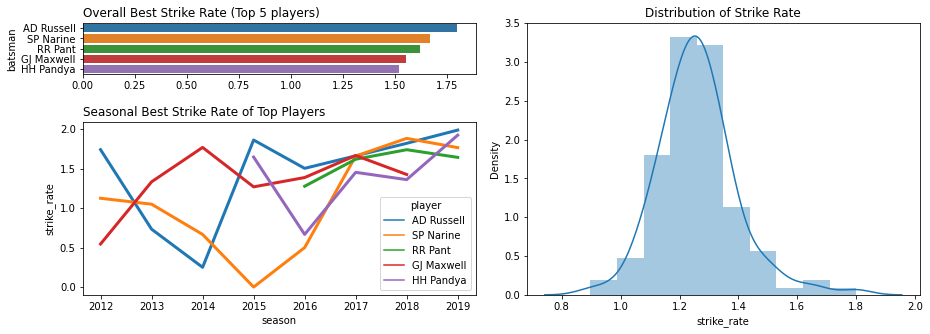

In [118]:
# Visualize the results
fig = plt.figure(figsize = (15, 5))
gs = gridspec.GridSpec(4,4 , figure = fig, wspace = 0.3, hspace = 1.5, height_ratios= [1, 0.5, 0.5, 0.5])
fig.tight_layout(pad = 3)

axe1 = fig.add_subplot(gs[0, :2])
sns.barplot(ax = axe1,x = "strike_rate", y = "batsman", 
            data = overall_strike_rate.head(), palette = "tab10").set_title("Overall Best Strike Rate (Top 5 players)", loc = "left")

axe2 = fig.add_subplot(gs[1:, :2])
sns.lineplot(ax = axe2,x = "season", y = "strike_rate", hue = "player", linewidth = 3, 
            data = strike_rate_df, palette = "tab10").set_title("Seasonal Best Strike Rate of Top Players", loc = "left")

axe3 = fig.add_subplot(gs[:, 2:])
sns.distplot(overall_strike_rate["strike_rate"],  bins = 10, norm_hist= True, ax = axe3).set_title("Distribution of Strike Rate")

axe1.xaxis.label.set_visible(False)
#axe2.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0)

**Explanation:**

AD Russell and SP Narine has shown their improvement in last seasons. 

AD Russell has the highest strike rate score throughout all season. 


# 8. Bowling Performance

A way to rank players with playing style : bowling is 

Dot Ball % – the percentage of balls bowled where no run is scored

Ref: [T20 Player Index](https://t20playerindex.com/t20-player-index-frequently-asked-questions/)

8.1 Work Flow

Same as Strike rate

* for overall
* for seasonal performance of highest in overall
* visualize

In [37]:
# overall dot ball

bowling_df = deliveries[["bowler", "total_runs", "season"]]

bowling_count = bowling_df.groupby("bowler", as_index = False).count().sort_values("bowler")
bowling_count.rename(columns = {"total_runs":"bowling_count"}, inplace = True)
bowling_count = bowling_count.drop(["season"], axis = 1)

zero_run_count = bowling_df[bowling_df["total_runs"] == 0].groupby("bowler", as_index = False).count().sort_values("bowler")
zero_run_count.rename(columns = {"total_runs": "zero_run_count"}, inplace  = True)
zero_run_count = zero_run_count.drop(["season"], axis = 1)

dot_ball_df = pd.merge(bowling_count, zero_run_count, on = "bowler")

dot_ball_df["Dot_ball_Percentage"] = round(dot_ball_df["zero_run_count"] / dot_ball_df["bowling_count"] * 100 , 3)

# Filter out those who bowled 10 balls and less
dot_ball_df_filtered = dot_ball_df[dot_ball_df["bowling_count"] > int(dot_ball_df["bowling_count"].mean()) ].sort_values("Dot_ball_Percentage", ascending = False)

In [38]:
# Seasonal for highest scorer in overall

interested_bowlers = dot_ball_df_filtered["bowler"].values[0:5]
dot_ball_season = pd.DataFrame(columns = ["season", "bowler", "Dot_ball_Percentage"])

for season in sorted(deliveries.season.unique()):
  for bowler in interested_bowlers:

    temp_dict = {}
    temp_dict["season"] = [season]
    temp_dict["bowler"] = [bowler]

    temp_dict["Dot_ball_Percentage"] = [100 * bowling_df[(
        bowling_df["season"] == season) & (bowling_df["bowler"]==bowler) & (bowling_df["total_runs"]== 0)].
        count().values[0] / bowling_df[(bowling_df["season"] == season) & (bowling_df["bowler"]==bowler)].count().values[0]]


    temp_df = pd.DataFrame.from_dict(temp_dict)
    dot_ball_season = pd.concat([dot_ball_season, temp_df], ignore_index=True)


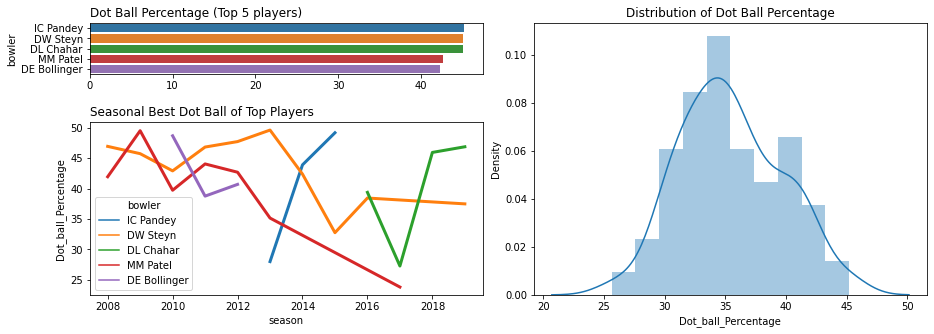

In [119]:
#visualize

fig = plt.figure(figsize = (15, 5))
gs = gridspec.GridSpec(4,4 , figure = fig, wspace = 0.3, hspace = 1.5, height_ratios= [1, 0.5, 0.5, 0.5])

fig.tight_layout(pad = 3)

axe1 = fig.add_subplot(gs[0, :2])
sns.barplot(ax = axe1, x = "Dot_ball_Percentage", y = "bowler", 
            data = dot_ball_df_filtered.head(), palette = "tab10").set_title("Dot Ball Percentage (Top 5 players)", loc = "left")

axe2 = fig.add_subplot(gs[1:, :2])
sns.lineplot(ax = axe2, x = "season", y = "Dot_ball_Percentage", hue = "bowler", linewidth =3,
             data = dot_ball_season, palette = "tab10").set_title("Seasonal Best Dot Ball of Top Players", loc = "left")

axe3 = fig.add_subplot(gs[:, 2:])
sns.distplot(dot_ball_df_filtered["Dot_ball_Percentage"], bins = 10, kde = True, norm_hist = True).set_title("Distribution of Dot Ball Percentage")

axe1.xaxis.label.set_visible(False)
#axe2.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0)

**Explanation:**

IC Pandey is being the highest in dot ball % bowling analysis. 

Let's see if he participated in seasons other than in chart. 

In [52]:
print("Number of matches IC Pandey participated in 2008~2012 and 2016~2019 : {} matches.".format(
    deliveries[(deliveries["bowler"] == "IC Pandey")&((deliveries["season"]<2013) | (deliveries["season"] > 2015))].count()[0]
))
print("Number of matches DL Chahar participated before 2016 : {} matches.".format(
    deliveries[(deliveries["bowler"] == "DL Chahar") & (deliveries["season"] < 2016)].count()[0]
))

Number of matches IC Pandey participated in 2008~2012 and 2016~2019 : 0 matches.
Number of matches DL Chahar participated before 2016 : 0 matches.


**Explanation:**

IC Pandey no longer participate in IPL after getting highest dot ball% in 2013. 

The second player in the list is DW Steyn, the interested highest scorer currently. 

The third player in list DL Chahar is also in watch list for his performance in comming seasons.



---



                                                                                                                                        --- End ---






---



